A $\Pi$-Day Notebook for NLP
========

- Jacob Eisenstein
- 3/14/2018
- For CS4650/7650 at Georgia Tech

To celebrate $\pi$-day, this notebook describes one way in which $\pi$ arises in natural language processing.

In [65]:
import numpy as np
from scipy.stats import beta, binom

import matplotlib.pyplot as plt
%matplotlib inline

## Generative models

Classical NLP relies heavily on *generative models* of the form $p(x \mid y)$, where $y$ is a label, and $x$ is a word or vector of word counts:

- In a Naive Bayes classifier, we compute $p(\vec{x} \mid y)$, where $y$ is a label and $\vec{x}$ is a bag-of-words vector.
- In a Hidden Markov Model, we compute $p(x \mid y)$, where $y$ is a tag (such as a part-of-speech), and $x$ is a word. 
- In a trigram language model, we compute $p(w_m \mid w_{m-1}, w_{m-2})$, where $w_m$ is token $m$ in a sequence.

Each of these models involves estimating a parameter vector $\vec{\theta}_y$, where $\theta_{y,w}$ is the probability of word $w$ given $y$, which could be a label, a tag, or a bigram context. A persistent problem with all these models is *sparsity*: if the word $w$ is rare, then the parameter $\theta_{y,w}$ will be difficult to estimate accurately from finite data. 

For example, the word "bicycle" appears only once in the [Universal Dependencies](http://universaldependencies.org/) English treebank; it is tagged as a noun, among 35000 other nouns. 

- Suppose that the true probability $P(\text{bicycle} \mid N) = \frac{1}{35000}.$ 
- Suppose that the nouns in the UD treebank data are a random sample. 
- If we drew another random sample, how often would we get a count of $1$ for bicycle as a noun?

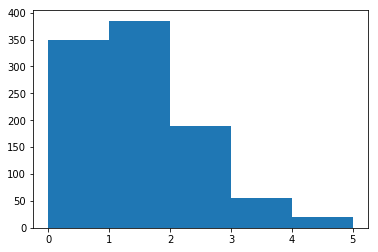

In [18]:
plt.hist((np.random.rand(35000,1000) < 1/35000.).sum(axis=0),[0,1,2,3,4,5]);

According to this simulation:

- In 35% of the simulated UD treebanks, "bicycle" never appears
- In 38% of the treebanks, it appears once
- In 19% of the treebanks, it appears twice
- In the remaining 8% of treebanks, it appears more than twice

## Smoothing

Clearly, we cannot naively trust the empirical frequencies that we observe from a treebank. The usual solution is *smoothing*: artificially smooth out the empirical probabilities so that they will be more uniform, and less dependent on the data:
\begin{equation}
\hat{\theta}_{y,w} \triangleq \frac{n_{y,w} + \alpha}{N_y + V\alpha}
\end{equation}
where,
- $n_{y,w}$ is the count of word $w$ with label $y$
- $N_y$ is the total count of label $y$
- $\alpha>0$ is some arbitrary smoothing constant
- $V$ is the size of the vocabulary. 

This method of computing probabilities increases bias (since real data is probably not uniformly distributed), but it decreases variance (since the estimates are less dependent on the finite sample that we use to compute them).

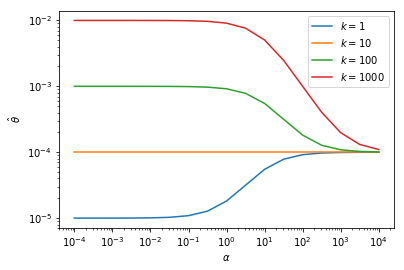

In [99]:
N = 1e5
V = 1e4
alpha = np.logspace(-4,4,17)
for k_i in [1,10,100,1000]:
    plt.loglog(alpha,(k_i+alpha)/(N + V*alpha))
plt.ylabel("$\\hat{\\theta}$")
plt.xlabel("$\\alpha$")
plt.legend(["$k=1$","$k=10$","$k=100$","$k=1000$"]);

As the amount of smoothing increases, the probabilities converge to the same value, regardless of the counts. This means that bias increases with $\alpha$, while variance decreases.

### Smoothing: a probabilistic justification

Additive smoothing can be justified as a *maximum a posteriori (MAP)* estimate of $\vec{\theta}_{y,w}$:
\begin{equation}
P(\vec{\theta}_y \mid \vec{x}^{(TR)}) \propto P(\vec{x}_{(TR)} \mid \vec{\theta}_{y}) P(\vec{\theta}_{y}),
\end{equation}
where $\vec{x}^{(TR)}$ is a vector of word counts from instances with label $y$ in a *training set*. 

The *likelihood* $P(\vec{x}^{(TR)} \mid \vec{\theta}_{y})$ follows a multinomial distribution,
\begin{equation}
P(\vec{x}^{(TR)} \mid \vec{\theta}_{y}) \propto \prod_w \theta_{y,w}^{x^{(TR)}_w}
\end{equation}

What about the *prior*, $P(\vec{\theta}_{y})$? Since $\vec{\theta}_{y}$ is a discrete probability distribution, a natural choice is the [symmetric Dirichlet distribution](https://en.wikipedia.org/wiki/Dirichlet_distribution),
\begin{equation}
P(\vec{\theta}_{y}; a) \propto \prod_w \theta_{y,w}^{a - 1}
\end{equation}
where $a > 0$ is a parameter of the prior. 

Here is an amazing property of the Dirichlet distribution, which explains why it is the right choice for the prior: if the prior is Dirichlet and the likelihood is multinomial, then the posterior $P(\vec{\theta}_y \mid \vec{x}^{(TR)})$ is also a Dirichlet distribution, with parameters $\vec{x}^{(TR)} + a$:
\begin{equation}
\vec{\theta}_y \sim \text{Dirichlet}(\vec{x}^{(TR)} + a)
\end{equation}

Furthermore, the modal value of this distribution --- the *maximum a posteriori* estimate --- is simply:
\begin{equation}
\hat{\theta}_{y,w} = \frac{x_w^{(TR)} + a - 1}{V(a - 1) + \sum_{w'} x^{(TR)}_{w'}}
\end{equation}

This is identical to the smoothed estimate, when $\alpha = a - 1$. Let's check that this is really the maximum a posterior estimate.

In [103]:
from scipy.stats import dirichlet

In [125]:
V = 10000
a = 1.5 # parameter of the Dirichlet prior
N = 1e6

# generate the true theta
theta_true = np.random.dirichlet(a * np.ones(V))
# generate some observed counts
x_tr = np.random.multinomial(N,theta_true)

log_likelihood = lambda theta_hat : np.dot(np.log(theta_hat),x_tr)
log_prior = lambda theta_hat : dirichlet.logpdf(theta_hat,a*np.ones(V))
log_posterior = lambda theta_hat : log_likelihood(theta_hat) + log_prior(theta_hat)

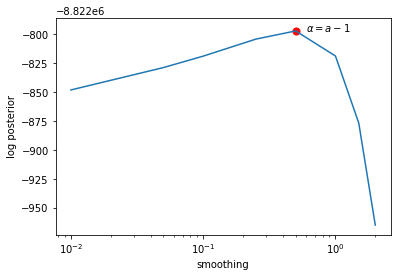

In [126]:
smoothers = [0.01,0.05,0.1,0.25,0.5,1,1.5,2]
log_posteriors = [log_posterior((x_tr + smoother)/(x_tr.sum() + V * smoother)) for smoother in smoothers]
plt.semilogx(smoothers,log_posteriors)
plt.scatter(a-1,log_posterior((x_tr + a-1)/(x_tr.sum()+V*(a-1))),50,color='r')
plt.text(a-1+.1,log_posterior((x_tr + a-1)/(x_tr.sum()+V*(a-1))),"$\\alpha = a-1$")
plt.ylabel("log posterior")
plt.xlabel("smoothing");

As predicted, setting the smoothing equal to $a - 1$ maximizes the posterior log-probability. 

In real situations, the parameter $a$ is not known, but [it can be estimated from data](https://tminka.github.io/papers/dirichlet/minka-dirichlet.pdf).

## All your Bayes: from smoothing to marginalization

Some people feel that smoothing has an unsatisfying "two step" feel to it:

- Use the training data and the smoothing hyperparameter to estimate $\hat{\theta}$
- Use the estimate $\hat{\theta}$ to compute the probability of the observed data $P(\vec{x} \mid y)$

Rather than using the *point estimate* $\hat{\theta}$, it would be nicer to consider all possible values for $\theta$. This is the [Bayesian](https://en.wikipedia.org/wiki/Bayesian_inference) approach. 

Specifically, we would like to compute the *posterior predictive distribution*,
\begin{align}
P(\vec{x} \mid y, \vec{x}^{(TR)}; a) = &{} \int P(\vec{x} | y, \vec{\theta}_{y}) P(\vec{\theta}_{y} \mid \vec{x}^{(TR)}; a) d\vec{\theta}_{y}
\end{align}
If we could solve this integral, we would never need to choose any specific value for $\vec{\theta}_{y}$. Instead, we marginalize over all possible values, with each value counting in proportion to its posterior probability $P(\vec{\theta}_{y} \mid x^{(TR)}; a)$. 

Integrating over the vector $\vec{\theta}$ may not seem promising, but miraculously, this integral has a closed form solution! 

\begin{align}
P(\vec{x} \mid y, \vec{x}^{(TR)}; a) = &{} \int P(\vec{x} | y, \vec{\theta}_{y}) P(\vec{\theta}_{y} \mid \vec{x}^{(TR)}; a) d\vec{\theta}_{y}\\
\propto &{} \prod_w \frac{\Gamma(x_w + x^{(TR)}_w + a_w)}{x_w! \Gamma(x^{(TR)}_w + a_w)}
\end{align}

The solution is expressed in terms of the [**Gamma function**](https://en.wikipedia.org/wiki/Gamma_function), $\Gamma(n)$. It is a generalization of the factorial function: for non-negative integer inputs $\Gamma(n) = (n-1)!$.

In [135]:
from scipy.special import gamma, factorial

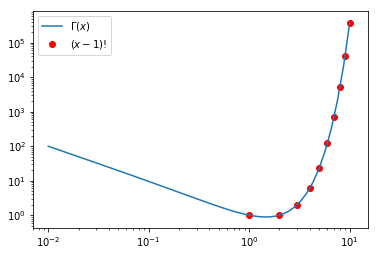

In [171]:
x = np.logspace(-2,1)
plt.loglog(x,gamma(x))
plt.scatter(np.linspace(1,10,10),factorial(np.linspace(1,10,10)-1),color='r')
plt.legend(['$\\Gamma(x)$','$(x-1)!$']);

Note that the Gamma function accepts inputs that are less than one. This scenario is relevant for natural language processing: in many applications, word distributions are sparse, assigning high probability to a few words, and very low probability to everything else. To obtain such sparsity, we can choose a prior $\vec{\theta} \sim \text{Dirichlet}(a)$, where $a < 1$. 

A particularly common choice is $a = \frac{1}{2}$. In this case, the value $\Gamma(\frac{1}{2})$ will appear in the denominator of the marginal likelihood for all words that are unseen in the training data.

Given that $\Gamma(a) = (a-1)!$ when $a$ is a positive integer, it may be hard to see what the output should look like when $a \in (0,1)$. [**Euler's reflection formula**](https://en.wikipedia.org/wiki/Reflection_formula) gives an answer:

\begin{align*}
\Gamma(a) \Gamma(1-a) = & \frac{\pi}{\sin a \pi}\\
\Gamma\left(\frac{1}{2}\right) = & \sqrt{\frac{\pi}{\sin \frac{\pi}{2}}}\\
= & \sqrt{\pi}\\
\end{align*}

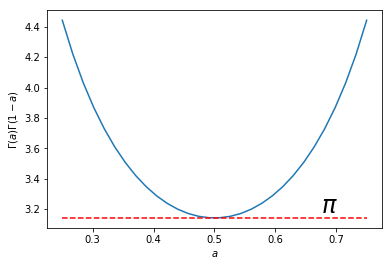

In [169]:
min_a = .25
max_a = .75
a_vals = np.linspace(min_a,max_a,30)
gamma_a = [gamma(a)*gamma(1-a) for a in a_vals]
plt.plot(a_vals,gamma_a)
plt.plot([min_a,max_a],[np.pi,np.pi],'r--')
plt.text(0.9*max_a,1.01*np.pi,'$\\pi$',fontsize=24)
plt.xlabel('$a$')
plt.ylabel('$\\Gamma(a)\\Gamma(1-a)$');